In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/kaggle/input/hate-speech-dataset/HateSpeechDatasetBalanced_reduced.csv')
df.head()

,Content,Label,clean_text
0,he don't want my surrender to my new math book...,1,he dont want my surrender to my new math book ...
1,pravi drzavnicki gov or sto god missile oh emu...,1,pravi drzavnicki gov or sto god missile oh emu...
2,i fucking hate going to my girlfriends house,0,i fucking hate going to my girlfriends house
3,asked that pretend son to b a time the son wou...,1,asked that pretend son to b a time the son wou...
4,well myself am connected to an ethnically jewi...,1,well myself am connected to an ethnically jewi...


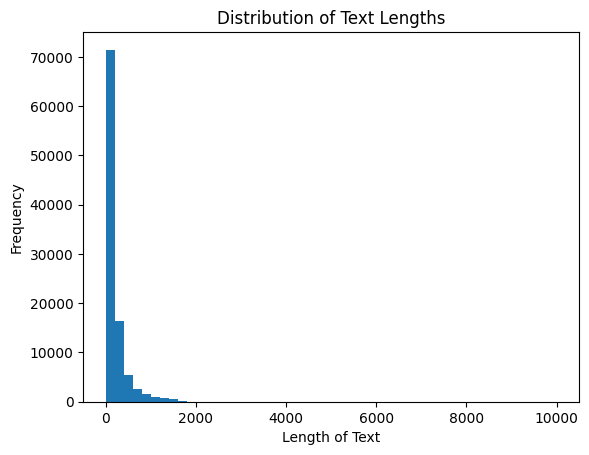

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(df['clean_text'].str.len(), bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()


In [4]:
max_length = int(np.percentile(df['clean_text'].str.len(), 95))
print(f"New Max Length: {max_length}")


New Max Length: 716


### Based on the plot of Distribution of Text Lengths, we can say that 95% of text sequences are 716 characters or fewer.

### 1. Label Distribution
- The dataset shows a nearly balanced distribution between the two classes:
  - **Negative (Label 0)**: ~50,000 instances.
  - **Positive (Label 1)**: ~50,000 instances.
- This balance ensures that classification models won't be biased toward any particular label, improving generalization performance.

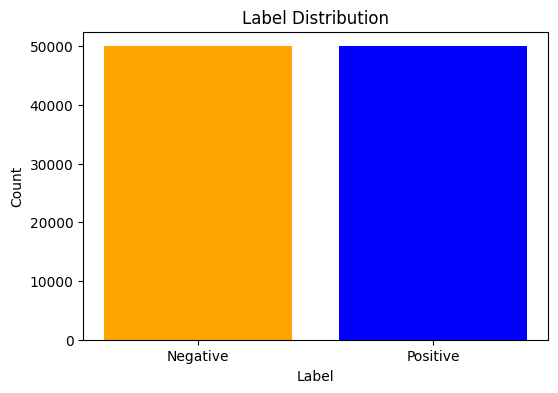

In [5]:
# Plotting label distribution
label_counts = df['Label'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

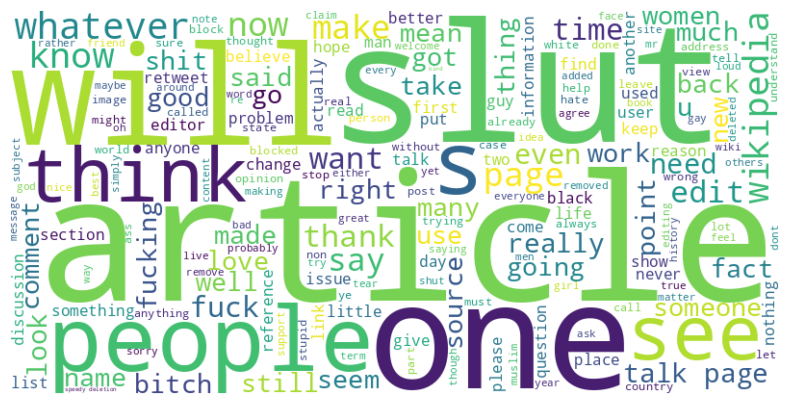

In [6]:
from wordcloud import WordCloud
from collections import Counter

# Join all text for word frequency analysis
all_text = ' '.join(df['clean_text'].tolist())

# Word frequency
word_freq = Counter(all_text.split())

# Plotting WordCloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and 'Label' is the target column
X = df['clean_text']
y = df['Label']

# Split into training (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [9]:
# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=10000)  # Adjust vocab_size as needed

# Fit the tokenizer on the training text
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_length = 716  # As previously determined
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [10]:
# Load GloVe embeddings
glove_file = '/kaggle/input/glove/other/default/1/glove.6B.100d.txt'  
embeddings_index = {}

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [11]:
embedding_dim = 100
vocab_size = 10000  
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:  # Only include words in the vocabulary
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import L2
from keras.callbacks import EarlyStopping

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False, input_length=max_length))

# First Bidirectional GRU Layer
model.add(Bidirectional(GRU(64, return_sequences=False, kernel_regularizer=L2(l2=1e-5))))
model.add(Dropout(0.4))

# Second Dense Layer with ReLU
model.add(Dense(32, activation='relu'))  
model.add(Dropout(0.5)) 

# Third Dense Layer with ReLU
model.add(Dense(16, activation='relu'))  
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))

learning_rate = 0.005

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [64]:
# Train the model
history = model.fit(
    X_train_pad, 
    y_train, 
    validation_data=(X_val_pad, y_val), 
    epochs=10,  
    batch_size=128,  
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.7011 - loss: 0.5648 - val_accuracy: 0.7970 - val_loss: 0.4428
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.7948 - loss: 0.4521 - val_accuracy: 0.8068 - val_loss: 0.4320
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.8072 - loss: 0.4322 - val_accuracy: 0.8065 - val_loss: 0.4416
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.8094 - loss: 0.4320 - val_accuracy: 0.8123 - val_loss: 0.4378
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.8169 - loss: 0.4177 - val_accuracy: 0.8162 - val_loss: 0.4196
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.8242 - loss: 0.4087 - val_accuracy: 0.8106 - val_loss: 0.4183
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.8334 - loss: 0.3969 - val_accuracy: 0.8120 - val_loss: 0.4289
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.8365 - loss: 0.3856 - 

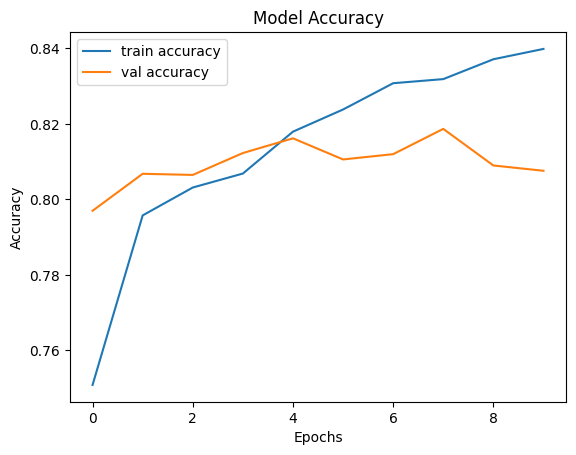

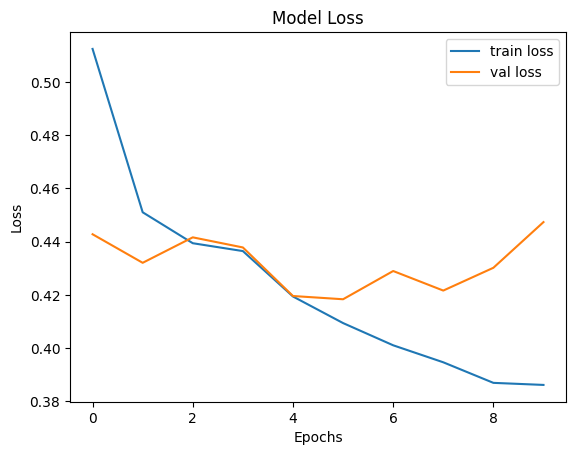

In [65]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [66]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8082 - loss: 0.4393
Test Loss: 0.4488891661167145
Test Accuracy: 0.805400013923645


In [67]:
# Save the model in HDF5 format
model.save('model_bidirictional_gru_acc_80.h5')